In [1]:
from function import *
from data_preparation import *
from evaluation import *

from openpyxl import Workbook
import pandas as pd
import numpy as np
import operator

from rdkit import Chem
from rdkit.Chem import AllChem

# Pre-prepare Data (Data Transformation)

In [2]:
# transform_data(output_file_name='../dataset/keck_complete.csv')

# Analysis

In [3]:
complete_df = pd.read_csv('../dataset/keck_complete.csv')

print complete_df.dtypes

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object


In [4]:
cnt_pria_retest = 0
cnt_pria_fp = 0
cnt_rmi_cdd = 0

cnt_dict = {}
for ix, row in complete_df.iterrows():
    cnt = 0
    if row['Keck_Pria_AS_Retest'] == 1:
        cnt_pria_retest += 1
        cnt += 1
    if row['Keck_Pria_FP_data'] == 1:
        cnt_pria_fp += 1
        cnt += 1
    if row['Keck_RMI_cdd'] == 1:
        cnt_rmi_cdd += 1
        cnt += 1
    if cnt not in cnt_dict.keys():
        cnt_dict[cnt] = 0
    cnt_dict[cnt] += 1

print 'pria retest active: {}\tpria fp active: {}\trmi cdd active: {}'.format(cnt_pria_retest, cnt_pria_fp, cnt_rmi_cdd)
print cnt_dict


print
analysis(complete_df)

pria retest active: 79	pria fp active: 24	rmi cdd active: 230
{0: 72094, 1: 325, 2: 4}

retest: 0, fp: 0, rmi: 0 	--- 49489
retest: 0, fp: 0, rmi: nan 	--- 22605
retest: 0, fp: 1, rmi: 0 	--- 19
retest: 0, fp: 1, rmi: 1 	--- 3
retest: 1, fp: 0, rmi: 0 	--- 58
retest: 1, fp: 0, rmi: nan 	--- 20
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 0, rmi: 1 	--- 227
retest: 1, fp: 1, rmi: nan 	--- 1


# Split data into k-fold

In [5]:
k = 3
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

9
(24142, 8)
(24142, 8)
(24139, 8)


In [6]:
k = 4
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [7]:
k = 5
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

9
(14486, 8)
(14484, 8)
(14486, 8)
(14484, 8)
(14483, 8)


# Merge data from splitting folds to form training and testing

In [8]:
dtype_list = {'Molecule': np.str,
              'SMILES':np.str,
              'Fingerprints': np.str,
              'Keck_Pria_AS_Retest': np.int64,
              'Keck_Pria_FP_data': np.int64,
              'Keck_Pria_Continuous': np.float64,
              'Keck_RMI_cdd': np.float64}
output_file_list = [directory + f_ for f_ in file_list]
print output_file_list[:3]
train_pd = read_merged_data(output_file_list[:3])
print output_file_list[3]
test_pd = read_merged_data([output_file_list[3]])

['../dataset/fixed_dataset/fold_5/file_0.csv', '../dataset/fixed_dataset/fold_5/file_1.csv', '../dataset/fixed_dataset/fold_5/file_2.csv']
../dataset/fixed_dataset/fold_5/file_3.csv


In [9]:
print 'This is training set'
analysis(train_pd)
print
print 'This is test set'
analysis(test_pd)

This is training set
retest: 0, fp: 0, rmi: 0 	--- 29693
retest: 0, fp: 0, rmi: nan 	--- 13563
retest: 1, fp: 0, rmi: nan 	--- 12
retest: 0, fp: 1, rmi: 1 	--- 3
retest: 1, fp: 0, rmi: 0 	--- 35
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 0, rmi: 1 	--- 136
retest: 0, fp: 1, rmi: 0 	--- 12
retest: 1, fp: 1, rmi: nan 	--- 1

This is test set
retest: 0, fp: 0, rmi: 0 	--- 9898
retest: 0, fp: 0, rmi: nan 	--- 4521
retest: 1, fp: 0, rmi: 0 	--- 12
retest: 0, fp: 0, rmi: 1 	--- 45
retest: 0, fp: 1, rmi: 0 	--- 4
retest: 1, fp: 0, rmi: nan 	--- 4


# Test feature- and label- extraction

In [10]:
print train_pd.dtypes

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object
(43456, 2)
(14484, 2)


# Test Single Classification

In [11]:
from single_task import *
import argparse
import pandas as pd
import csv
import numpy as np
import json
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score
from sklearn.cross_validation import StratifiedShuffleSplit
from function import *


def setup_model():
    model = Sequential()
    if batch_is_use:
        batch_normalizer = BatchNormalization(epsilon=batch_normalizer_epsilon,
                                              mode=batch_normalizer_mode,
                                              axis=batch_normalizer_axis,
                                              momentum=batch_normalizer_momentum,
                                              weights=batch_normalizer_weights,
                                              beta_init=batch_normalizer_beta_init,
                                              gamma_init=batch_normalizer_gamma_init)
    layers = conf['layers']
    layer_number = len(layers)
    for i in range(layer_number):
        init = layers[i]['init']
        activation = layers[i]['activation']
        if i == 0:
            hidden_units = int(layers[i]['hidden_units'])
            dropout = float(layers[i]['dropout'])
            model.add(Dense(hidden_units, input_dim=input_layer_dimension, init=init, activation=activation))
            model.add(Dropout(dropout))
        elif i == layer_number-1:
            if batch_is_use:
                model.add(batch_normalizer)
            # output_layer_dimension = layers[i]['output_layer_dimension']
            model.add(Dense(output_layer_dimension, init=init, activation=activation))
        else:
            hidden_units = int(layers[i]['hidden_units'])
            dropout = float(layers[i]['dropout'])
            model.add(Dense(hidden_units, init=init, activation=activation))
            model.add(Dropout(dropout))
    return model


def train_and_predict(X_train, y_train, X_val, y_val, X_test, y_test, PMTNN_weight_file):
    model = setup_model()
    if early_stopping_option == 'auc':
        early_stopping = KeckCallBackOnAUC(X_train, y_train, X_val, y_val, patience=early_stopping_patience)
        callbacks = [early_stopping]
    elif early_stopping_option == 'precision':
        early_stopping = KeckCallBackOnPrecision(X_train, y_train, X_val, y_val, patience=early_stopping_patience)
        callbacks = [early_stopping]
    else:
        callbacks = []

    model.compile(loss=compile_loss, optimizer=compile_optimizer)
    model.fit(X_train, y_train, nb_epoch=fit_nb_epoch, batch_size=fit_batch_size, verbose=fit_verbose,
              validation_data=(X_val, y_val), callbacks=callbacks)
    model.save_weights(PMTNN_weight_file)

    if early_stopping_option == 'auc' or early_stopping_option == 'precision':
        model = early_stopping.get_best_model()
    y_pred_on_train = model.predict(X_train)
    y_pred_on_val = model.predict(X_val)
    y_pred_on_test = model.predict(X_test)

    print
    print('train precision: {}'.format(average_precision_score(y_train, y_pred_on_train)))
    print('train auc: {}'.format(roc_auc_score(y_train, y_pred_on_train)))
    print('validation precision: {}'.format(average_precision_score(y_val, y_pred_on_val)))
    print('validation auc: {}'.format(roc_auc_score(y_val, y_pred_on_val)))
    print('test precision: {}'.format(average_precision_score(y_test, y_pred_on_test)))
    print('test auc: {}'.format(roc_auc_score(y_test, y_pred_on_test)))

    for EF_ratio in EF_ratio_list:
        n_actives, ef, ef_max = enrichment_factor_single(y_test, y_pred_on_test, EF_ratio)
        print('ratio: {}, EF: {}, EF_max: {}\tactive: {}'.format(EF_ratio, ef, ef_max, n_actives))

        
def get_EF_score_with_existing_model(X_test, y_test, file_path, EF_ratio):
    model = setup_model()
    model.load_weights(file_path)
    y_pred_on_test = model.predict(X_test)
    n_actives, ef = enrichment_factor(y_test, y_pred_on_test, EF_ratio)
    print('test precision: {}'.format(average_precision_score(y_test, y_pred_on_test)))
    print('test auc: {}'.format(roc_auc_score(y_test, y_pred_on_test)))
    print('EF: {},\tactive: {}'.format(ef, n_actives))    
    return

def extract_feature_and_label(data_pd,
                              feature_name,
                              label_name_list):
    X_data = np.zeros(shape=(data_pd.shape[0], 1024))
    y_data = np.zeros(shape=(data_pd.shape[0], len(label_name_list)))
    index = 0
    print 'whole shpae ', data_pd.shape
    for _, row in data_pd.iterrows():
        feature = list(row[feature_name])
        labels = row[label_name_list]
        X_data[index] = np.array(feature)
        y_data[index] = np.array(labels)
        index += 1
    X_data = X_data.astype(float)
    y_data = y_data.astype(int)

    # In case we just train on one target
    # y would be (n,) vector
    # then we should change it to (n,1) 1D matrix
    # to keep consistency
    print y_data.shape
    if y_data.ndim == 1:
        n = y_data.shape[0]
        y_data = y_data.reshape(n, 1)

    return X_data, y_data

if __name__ == '__main__':
    config_json_file = '../json/classification.json'
    PMTNN_weight_file = 'temp.h5'
    
    
    with open(config_json_file, 'r') as f:
        conf = json.load(f)
    
    X_train, y_train = extract_feature_and_label(train_pd,
                                                 feature_name='Fingerprints',
                                                 label_name_list=['Keck_Pria_AS_Retest'])
    X_test, y_test = extract_feature_and_label(test_pd,
                                               feature_name='Fingerprints',
                                               label_name_list=['Keck_Pria_AS_Retest'])

    cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
    for t_index, val_index in cross_validation_split:
        X_t, X_val = X_train[t_index], X_train[val_index]
        y_t, y_val = y_train[t_index], y_train[val_index]

    input_layer_dimension = 1024
    output_layer_dimension = 1

    print 'done'

Using Theano backend.
Using gpu device 0: Tesla K40m (CNMeM is disabled, CuDNN 4004)


whole shpae  (43456, 8)
(43456, 1)
whole shpae  (14484, 8)
(14484, 1)
done


In [12]:
print X_t.shape
print y_t.shape
print X_val.shape
print y_val.shape
print X_test.shape
print y_test.shape

(36937, 1024)
(36937, 1)
(6519, 1024)
(6519, 1)
(14484, 1024)
(14484, 1)


In [14]:
    PMTNN_weight_file = 'temp.h5'
    with open(config_json_file, 'r') as f:
        conf = json.load(f)
    early_stopping_patience = conf['fitting']['early_stopping']['patience']
    early_stopping_option = conf['fitting']['early_stopping']['option']

    fit_nb_epoch = conf['fitting']['nb_epoch']
    fit_batch_size = conf['fitting']['batch_size']
    fit_verbose = conf['fitting']['verbose']

    compile_loss = conf['compile']['loss']
    compile_optimizer_option = conf['compile']['optimizer']['option']
    if compile_optimizer_option == 'sgd':
        sgd_lr = conf['compile']['optimizer']['sgd']['lr']
        sgd_momentum = conf['compile']['optimizer']['sgd']['momentum']
        sgd_decay = conf['compile']['optimizer']['sgd']['decay']
        sgd_nestrov = conf['compile']['optimizer']['sgd']['nestrov']
        compile_optimizer = SGD(lr=sgd_lr, momentum=sgd_momentum, decay=sgd_decay, nesterov=sgd_nestrov)
    else:
        adam_lr = conf['compile']['optimizer']['adam']['lr']
        adam_beta_1 = conf['compile']['optimizer']['adam']['beta_1']
        adam_beta_2 = conf['compile']['optimizer']['adam']['beta_2']
        adam_epsilon = conf['compile']['optimizer']['adam']['epsilon']
        compile_optimizer = Adam(lr=adam_lr, beta_1=adam_beta_1, beta_2=adam_beta_2, epsilon=adam_epsilon)

    batch_is_use = conf['batch']['is_use']
    if batch_is_use:
        batch_normalizer_epsilon = conf['batch']['epsilon']
        batch_normalizer_mode = conf['batch']['mode']
        batch_normalizer_axis = conf['batch']['axis']
        batch_normalizer_momentum = conf['batch']['momentum']
        batch_normalizer_weights = conf['batch']['weights']
        batch_normalizer_beta_init = conf['batch']['beta_init']
        batch_normalizer_gamma_init = conf['batch']['gamma_init']

    EF_ratio_list = conf['enrichment_factor']['ratio_list']

    train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)


Epoch 1/200
Precision Train: 0.003116 ---- Precision Val: 0.001521
AUC Train: 0.664845 ---- AUC Val: 0.636802

Epoch 2/200
Precision Train: 0.031944 ---- Precision Val: 0.001054
AUC Train: 0.818519 ---- AUC Val: 0.537272

Epoch 3/200
Precision Train: 0.067116 ---- Precision Val: 0.001243
AUC Train: 0.884677 ---- AUC Val: 0.606397

Epoch 4/200
Precision Train: 0.128786 ---- Precision Val: 0.001143
AUC Train: 0.922156 ---- AUC Val: 0.559560

Epoch 5/200
Precision Train: 0.240005 ---- Precision Val: 0.001352
AUC Train: 0.946290 ---- AUC Val: 0.627347

Epoch 6/200
Precision Train: 0.266986 ---- Precision Val: 0.002270
AUC Train: 0.955897 ---- AUC Val: 0.734073

Epoch 7/200
Precision Train: 0.459200 ---- Precision Val: 0.002148
AUC Train: 0.978542 ---- AUC Val: 0.771257

Epoch 8/200
Precision Train: 0.453983 ---- Precision Val: 0.003480
AUC Train: 0.987470 ---- AUC Val: 0.800105

Epoch 9/200
Precision Train: 0.484684 ---- Precision Val: 0.003698
AUC Train: 0.994273 ---- AUC Val: 0.860170



# Test evaluation metrics

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 5.0)

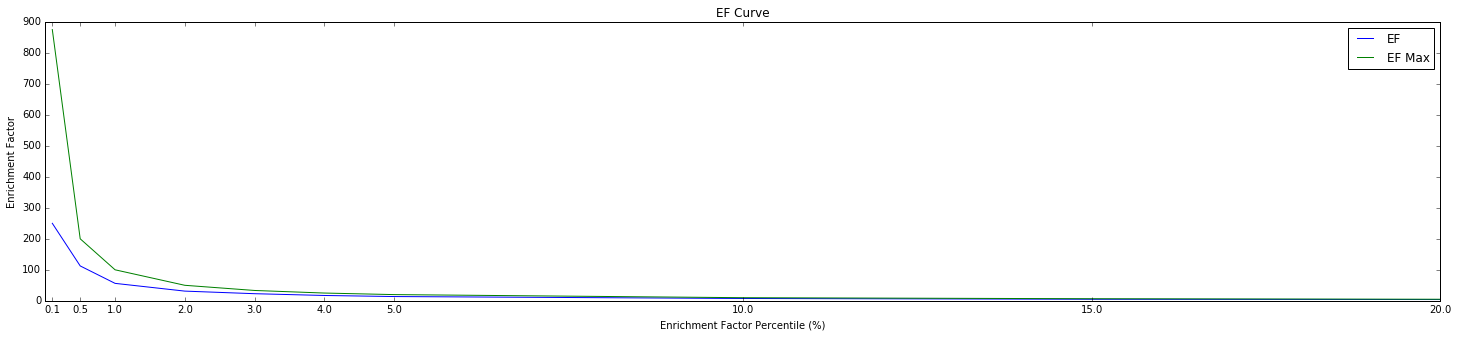

In [16]:
def plot_EF_score_with_existing_model(X_test, y_test, file_path, EF_ratio=0.1):
    model = setup_model()
    model.load_weights(file_path)
    y_pred_on_test = model.predict(X_test)
    EF_ratio_list = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 15, 20]
    EF_ratio_list = np.array(EF_ratio_list) / 100.0
    
    ef_values = []
    ef_max_values = []
    for EF_ratio in EF_ratio_list:
        n_actives, ef, ef_max = enrichment_factor_single(y_test, y_pred_on_test, EF_ratio)
        ef_values.append(ef)
        ef_max_values.append(ef_max)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_values)
    plt.plot(x_axis, y_axis)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_max_values)
    plt.plot(x_axis, y_axis)
    
    plt.legend(['EF', 'EF Max'])
    
    plt.xticks(EF_ratio_list, [str(val*100) for val in EF_ratio_list])
    plt.xlabel('Enrichment Factor Percentile (%)')
    plt.ylabel('Enrichment Factor')
    plt.title('EF Curve')
    plt.show()
    return

plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)